In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import RobertaTokenizer, RobertaModel, Trainer, TrainingArguments

from pathlib import Path 

import os

import torch
import torch.optim as optim

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

pd.plotting.register_matplotlib_converters()
%matplotlib inline


%load_ext autoreload
%autoreload 2
from help_tool import help_tool

# Setting graph parameters
sns.set_theme(style='white')

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
clean_data = help_tool.csv_download(
    r'Archive\clean_data.csv').drop(columns='Unnamed: 0')

In [26]:
labels = clean_data.drop(columns=['id', 'comment_text']).columns
# X = clean_data['comment_text']

In [64]:
assert all(text is not None for text in texts_train), "Some texts in training data are None"
assert all(label is not None for label in labels_train), "Some labels in training data are None"


In [46]:

# Define a function to split and combine datasets
def split_and_combine(df, label_column, train_ratio=0.8):
    # Separate positive and negative cases
    pos_df = df[df[label_column] == 1]
    neg_df = df[df[label_column] == 0]
    
    # Split positive cases
    pos_train_df, pos_val_df = train_test_split(pos_df, test_size=1-train_ratio, stratify=pos_df[label_column])
    
    # Split negative cases
    neg_train_df, neg_val_df = train_test_split(neg_df, test_size=1-train_ratio, stratify=neg_df[label_column])
    
    # Combine the datasets
    train_df = pd.concat([pos_train_df, neg_train_df])
    val_df = pd.concat([pos_val_df, neg_val_df])
    
    # Shuffle the combined datasets
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    val_df = val_df.sample(frac=1).reset_index(drop=True)
    
    return train_df, val_df

# Split datasets for each label
#train_df, val_df = clean_data.drop(columns='id').copy(), clean_data.drop(columns='id').copy()  # Start with the full dataset
for label in labels:
    train_df, val_df = split_and_combine(clean_data, label)


In [47]:
# Print the shape of the splits
print(f'Training set: {train_df.shape}, {val_df.shape}')

Training set: (126057, 8), (31515, 8)


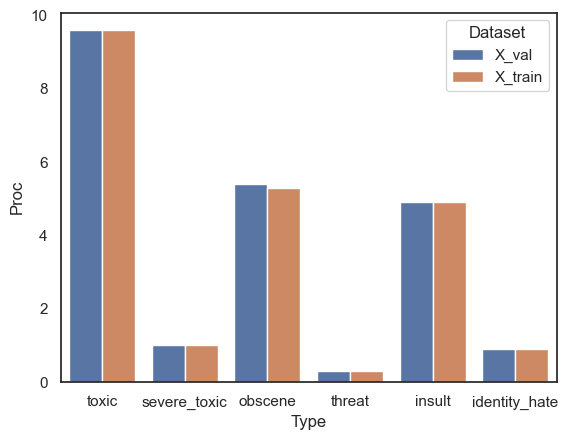

In [48]:
sns.barplot(data=help_tool.model_dataset_distribution(clean_data, train_df, val_df), hue='Dataset', y='Proc', x='Type')
plt.show()

In [55]:
clean_data[clean_data['comment_text'].apply(lambda x: len(x.split(" "))) == 0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [49]:
# Convert to lists
texts_train = train_df['comment_text'].tolist()
labels_train = train_df[labels].values
texts_val = val_df['comment_text'].tolist()
labels_val = val_df[labels].values


In [50]:
train_df[train_df['comment_text'] == None]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [13]:
# Check for None values in texts and labels
print("Checking for None values in training data...")
print(f"None in texts_train: {any(text is None for text in texts_train)}")
print(f"None in labels_train: {any(label is None for label in labels_train)}")

print("Checking for None values in validation data...")
print(f"None in texts_val: {any(text is None for text in texts_val)}")
print(f"None in labels_val: {any(label is None for label in labels_val)}")


Checking for None values in training data...
None in texts_train: False
None in labels_train: False
Checking for None values in validation data...
None in texts_val: False
None in labels_val: False


In [67]:
# Custom model class to apply sigmoid activation to the output layer
class RobertaForMultiLabelClassification(nn.Module):
    def __init__(self, model_name, num_labels):
        super(RobertaForMultiLabelClassification, self).__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0][:, 0, :]  # take the representation of [CLS] token
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        probs = self.sigmoid(logits)
        return probs

# Define the dataset class
class ToxicCommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text, 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_len, 
            return_tensors='pt'
        )

        # Add debug prints
        if text is None:
            print(f"Text is None at index {idx}")
        if label is None:
            print(f"Label is None at index {idx}")
        if any(val is None for val in encoding.values()):
            print(f"Encoding is None at index {idx} for text: {text}")

        # Corrected: Use clone().detach() to copy the tensor
        item = {key: val.squeeze().clone().detach() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.float).clone().detach()

        # Check if any item is None
        if any(v is None for v in item.values()):
            raise ValueError(f"NoneType found in the dataset at index {idx}. Text: {text}, Label: {label}")

        return item
    
# Modify the Trainer to use binary cross-entropy loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")

        
        
        # Check if labels and inputs are valid
        if labels is None or inputs['input_ids'] is None or inputs['attention_mask'] is None:
            raise ValueError("Found NoneType in inputs or labels. Please check the dataset and data loader.")

        # forward pass
        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

        # compute custom loss (binary cross-entropy)
        loss_fct = nn.BCELoss()
        loss = loss_fct(outputs, labels)
        return (loss, outputs) if return_outputs else loss


In [68]:
# Initialize tokenizer and custom model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMultiLabelClassification(model_name='roberta-base', num_labels=6)

c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
# Prepare datasets
train_dataset = ToxicCommentDataset(texts_train, labels_train, tokenizer, max_len=128)
val_dataset = ToxicCommentDataset(texts_val, labels_val, tokenizer, max_len=128)

In [70]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_total_limit=2
)


c:\Users\User\Desktop\Gintares_Projektai\Toxic-Comment-Classification\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [71]:
# Initialize the custom trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

In [72]:
# Train the model
trainer.train()

  0%|          | 0/47274 [00:00<?, ?it/s]

AssertionError: labels is None

In [ ]:

# Example of thresholding output during evaluation/prediction
def predict(text):
    model.eval()
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
    with torch.no_grad():
        probs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    preds = (probs > 0.5).int()
    return preds

# Example usage
sample_text = "Example toxic comment text"
prediction = predict(sample_text)
print("Predicted labels:", prediction)